In [12]:
import tensorflow as tf
from keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
DATA_DIR = "../Data/"
MODEL = "../DeepModels/"
LR = 0.001
BATCH_SIZE = 1024


In [14]:
Users_df = pd.read_csv(os.path.join(DATA_DIR,"users.csv"),engine="python",sep="\t",encoding="latin-1")
Users_df.head()

Movies_df = pd.read_csv(os.path.join(DATA_DIR,"movies.csv"),engine="python",sep="\t",encoding="latin-1")
Users_df.head()

Ratings_df = pd.read_csv(os.path.join(DATA_DIR,"ratings.csv"),engine="python",sep="\t",encoding="latin-1")
Ratings_df.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [15]:
max_user_id = Ratings_df["user_id"].max()
max_movie_id = Ratings_df["movie_id"].max()

Ratings_df["user_emb"] = Ratings_df["user_id"].apply(lambda x:x-1)
Ratings_df["movie_emb"] = Ratings_df["movie_id"].apply(lambda x:x-1)

print(f"max user id is : {max_user_id}")
print(f"max movie id is : {max_movie_id}")

max user id is : 6040
max movie id is : 3952


In [16]:
train_sample , val_sample = train_test_split(Ratings_df,test_size=0.1,random_state=18)

train_Users = train_sample["user_emb"].values
train_Movies = train_sample["movie_emb"].values
train_rating = train_sample["rating"].values

val_Users=val_sample["user_emb"].values
val_Movies=val_sample["movie_emb"].values
val_rating = val_sample["rating"].values

print(f"train users :{train_Users.shape}")
print(f"train movies :{train_Movies.shape}")
print(f"\nval users :{val_Users.shape}")
print(f"val moives :{val_Movies.shape}")

train users :(900188,)
train movies :(900188,)

val users :(100021,)
val moives :(100021,)


In [17]:
def load_dataset(user,movie,rating):
    user = tf.convert_to_tensor(user)
    movie = tf.convert_to_tensor(movie)
    rating = tf.convert_to_tensor(rating)

    return (user,movie),rating

def tfData(user,movie,rating):
    ds = tf.data.Dataset.from_tensor_slices((user,movie,rating))
    ds = ds.map(load_dataset,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = tfData(train_Users,train_Movies,train_rating)
val_ds = tfData(val_Users,val_Movies,val_rating)



In [18]:
ds = train_ds.take(3)
for (user,movie),rating in ds:
    print(user.shape[0])


1024
1024
1024


In [19]:
class Network(tf.keras.Model):
    def __init__(self,n_users,n_movies,factors_dim,reg_c = 1.0):

        super(Network,self).__init__()

        self.n_users = n_users
        self.n_movies = n_movies
        self.factors_dim = factors_dim
        self.reg_c = reg_c

        self.users_em = layers.Embedding(n_users,factors_dim)
        self.movies_em = layers.Embedding(n_movies,factors_dim)

    def call(self,inputs):
        users_id,movies_id = inputs


        users= self.users_em(users_id)
        movies = self.movies_em(movies_id)

        result = tf.reduce_sum(users * movies,axis = 1)


        return result

model = Network(max_user_id,max_movie_id,100)


ds = train_ds.take(1)

for x,y in ds :
    print(model(x).shape)
    print(y.shape)


(1024,)
(1024,)


In [20]:
def train(epochs,train_name="train"):

    loss_history = []
    val_loss_history = []

    best_val = np.inf 
    num_epochs = epochs
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss_fucntion = tf.keras.losses.MeanSquaredError()


    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        pbar = tqdm(total = train_Users.shape[0])
        pbar.set_description(f"Epoch {epoch}:")

        for idx,batch in enumerate(train_ds):
            (users_id,movies_id),targets = batch
            with tf.GradientTape() as tape :
                out = model([users_id,movies_id])
                loss = loss_fucntion(y_true=targets,y_pred=out)
            gradients = tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradients,model.trainable_variables))
            epoch_loss.append(loss)
            pbar.update(users_id.shape[0])
        pbar.close()
        for idx , val_batch in enumerate(val_ds):
            (users_id,movies_id),targets = val_batch
            out = model([users_id,movies_id])
            val_loss = loss_fucntion(y_true=targets,y_pred=out)

            epoch_val_loss.append(val_loss)
        

        epoch_mse = np.array(epoch_loss).mean()
        epoch_val_mse = np.array(epoch_val_loss).mean()

        print(f"Epoch {epoch} Mse:{epoch_mse:.3f},Rmse:{np.sqrt(epoch_mse):.3f} | val_mse:{epoch_val_mse:.3f},val_rmse:{np.sqrt(epoch_val_mse):.3f}")
        if epoch_val_mse < best_val:
            model.save(os.path.join(MODEL,"MatrixFactorization"))
            best_val = epoch_val_mse

        loss_history.append(epoch_mse)
        val_loss_history.append(epoch_val_mse)
    data = {
        "epoch":[i for i in range(num_epochs)],
        "loss":loss_history,
        "val_loss":val_loss_history
            }
    history_df = pd.DataFrame(data)
    return history_df

In [21]:
history = train(20)

Epoch 0:: 100%|██████████| 900188/900188 [00:35<00:00, 25210.28it/s]


Epoch 0 Mse:6.544,Rmse:2.558 | val_mse:1.002,val_rmse:1.001
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 1:: 100%|██████████| 900188/900188 [00:28<00:00, 31484.10it/s]


Epoch 1 Mse:0.883,Rmse:0.939 | val_mse:0.846,val_rmse:0.920
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 2:: 100%|██████████| 900188/900188 [00:31<00:00, 28963.19it/s]


Epoch 2 Mse:0.805,Rmse:0.897 | val_mse:0.801,val_rmse:0.895
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 3:: 100%|██████████| 900188/900188 [00:29<00:00, 30147.73it/s]


Epoch 3 Mse:0.754,Rmse:0.868 | val_mse:0.775,val_rmse:0.880
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 4:: 100%|██████████| 900188/900188 [00:35<00:00, 25467.80it/s]


Epoch 4 Mse:0.714,Rmse:0.845 | val_mse:0.760,val_rmse:0.872
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 5:: 100%|██████████| 900188/900188 [00:33<00:00, 26769.43it/s]


Epoch 5 Mse:0.678,Rmse:0.823 | val_mse:0.749,val_rmse:0.865
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 6:: 100%|██████████| 900188/900188 [00:30<00:00, 29581.28it/s]


Epoch 6 Mse:0.640,Rmse:0.800 | val_mse:0.742,val_rmse:0.861
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 7:: 100%|██████████| 900188/900188 [00:40<00:00, 22010.63it/s]


Epoch 7 Mse:0.601,Rmse:0.775 | val_mse:0.739,val_rmse:0.859
INFO:tensorflow:Assets written to: ../DeepModels/MatrixFactorization\assets


Epoch 8:: 100%|██████████| 900188/900188 [00:41<00:00, 21945.81it/s]


Epoch 8 Mse:0.560,Rmse:0.748 | val_mse:0.740,val_rmse:0.860


Epoch 9:: 100%|██████████| 900188/900188 [00:36<00:00, 24724.07it/s]


Epoch 9 Mse:0.518,Rmse:0.720 | val_mse:0.745,val_rmse:0.863


Epoch 10:: 100%|██████████| 900188/900188 [00:34<00:00, 26032.79it/s]


Epoch 10 Mse:0.476,Rmse:0.690 | val_mse:0.754,val_rmse:0.868


Epoch 11:: 100%|██████████| 900188/900188 [00:33<00:00, 26491.81it/s]


Epoch 11 Mse:0.436,Rmse:0.660 | val_mse:0.767,val_rmse:0.876


Epoch 12:: 100%|██████████| 900188/900188 [00:30<00:00, 29701.46it/s]


Epoch 12 Mse:0.399,Rmse:0.631 | val_mse:0.783,val_rmse:0.885


Epoch 13:: 100%|██████████| 900188/900188 [00:30<00:00, 29463.63it/s]


Epoch 13 Mse:0.366,Rmse:0.605 | val_mse:0.802,val_rmse:0.895


Epoch 14:: 100%|██████████| 900188/900188 [00:30<00:00, 29830.85it/s]


Epoch 14 Mse:0.337,Rmse:0.580 | val_mse:0.821,val_rmse:0.906


Epoch 15:: 100%|██████████| 900188/900188 [00:29<00:00, 30282.24it/s]


Epoch 15 Mse:0.312,Rmse:0.559 | val_mse:0.842,val_rmse:0.918


Epoch 16:: 100%|██████████| 900188/900188 [00:33<00:00, 26966.18it/s]


Epoch 16 Mse:0.291,Rmse:0.539 | val_mse:0.863,val_rmse:0.929


Epoch 17:: 100%|██████████| 900188/900188 [00:32<00:00, 27641.56it/s]


Epoch 17 Mse:0.273,Rmse:0.523 | val_mse:0.884,val_rmse:0.940


Epoch 18:: 100%|██████████| 900188/900188 [00:31<00:00, 28599.53it/s]


Epoch 18 Mse:0.258,Rmse:0.508 | val_mse:0.905,val_rmse:0.951


Epoch 19:: 100%|██████████| 900188/900188 [00:31<00:00, 28681.75it/s]


Epoch 19 Mse:0.245,Rmse:0.495 | val_mse:0.925,val_rmse:0.962


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


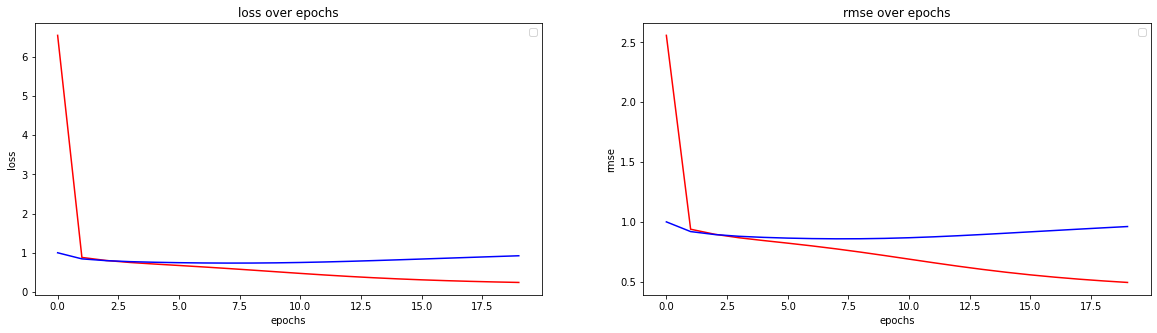

In [22]:
history["rmse"] = np.sqrt(history["loss"])
history["val_rmse"] = np.sqrt(history["val_loss"])
fig,ax= plt.subplots(1,2,figsize = (20,5))

infos = [["loss","val_loss"],["rmse","val_rmse"]]
x = np.arange(history.shape[0])

for i in range(2):
  ax[i].set_title(f"{infos[i][0]} over epochs")
  ax[i].set_ylabel(f"{infos[i][0]}")
  ax[i].set_xlabel(f"epochs")
  ax[i].plot(x,history[infos[i][0]].values,c="red")
  ax[i].plot(x,history[infos[i][1]].values,c = "blue")
  ax[i].legend()
